# Team 2
Names:
1. Akshay Kumar Rayapet Madhusudhan - 1002154477
2. Sudhamsh Rama - 1002210904

Link To Colab: https://colab.research.google.com/drive/10lAeG0JnsdHV69MBiTg8TJRvJEqE_Noc?usp=sharing

## Import libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from typing import Tuple, Iterable
import pickle

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import  DataLoader, random_split
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

## Check for GPU or TPU

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [ ]:
transform = torchvision.transforms.Compose( [torchvision.transforms.ToTensor(), torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

100%|██████████| 170498071/170498071 [00:08<00:00, 20303611.28it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(trainset), len(testset)

(50000, 10000)

In [ ]:
train_size = int(0.9 * len(trainset))
val_size = len(trainset) - train_size

train_subset, val_subset = random_split(trainset, [train_size, val_size])

In [ ]:
len(train_subset), len(val_subset)

(45000, 5000)

In [ ]:
batch_size = 32
train_loader = DataLoader(dataset=train_subset,batch_size=batch_size,shuffle=True)
val_loader = DataLoader(dataset=val_subset,batch_size=batch_size,shuffle=True)
test_loader = DataLoader(dataset=testset,batch_size=batch_size,shuffle=True)

## Define Model

### Model 1
for the below model, the input channels are 4 RBG and the number of output channels are increase as the network goes deeper

From, 32 -> 256 -> 1024 -> 256

After each convolutional layer, batch normalisation is applied, to normalise the output of the previous layer
The activation used us ReLU after each convolutional layer and fully connected layer.

Max Pooling layer is used to downsample the feature maps, reducing dimensions.

After all the layers we are going to flatten the output to a fully connected layer converting 3D tensors to 1D tensor.

At the end of the layers we are using nn.Linear and Dropout layer to prevent overfitting the model. Since we have 10 classes we are using 10 output united at the end

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(256, 1024, kernel_size=3, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(1024, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Flatten(),
            nn.Linear(256 * 4 * 4, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)


model = Net()
model.to(device)

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(256, 1024, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(1024, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), paddin

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.006, momentum=0.9)

## Fit Model

In [ ]:
num_epochs = 9

train_losses = []
train_accuracies = []

predictions = []
true_labels = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_images, batch_labels in train_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        outputs = model(batch_images)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs.data, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    model.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            true_labels.append(batch_labels)

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()

            _, predicted_labels = torch.max(outputs.data, 1)
            predictions.append(predicted_labels)
            val_total_samples += batch_labels.size(0)
            correct_val_predictions += (predicted_labels == batch_labels).sum().item()

    average_train_loss = total_loss / len(train_loader)
    training_accuracy = (correct_predictions / total_samples) * 100

    train_losses.append(average_train_loss)
    train_accuracies.append(training_accuracy)

    average_val_loss = total_val_loss / len(test_loader)
    validation_accuracy = (correct_val_predictions / val_total_samples) * 100

    print(f"Epoch={epoch + 1}, Training [Loss, accuracy]: [{average_train_loss:.4f}, {training_accuracy:.2f}%], \
    Validation [Loss,accuracy]: [{average_val_loss:.4f}, {validation_accuracy:.2f}%]")


Epoch=1, Training [Loss, accuracy]: [1.3251, 51.90%],     Validation [Loss,accuracy]: [0.4711, 66.26%]
Epoch=2, Training [Loss, accuracy]: [0.8922, 68.63%],     Validation [Loss,accuracy]: [0.4865, 66.00%]
Epoch=3, Training [Loss, accuracy]: [0.7190, 75.09%],     Validation [Loss,accuracy]: [0.3170, 78.44%]
Epoch=4, Training [Loss, accuracy]: [0.6037, 79.18%],     Validation [Loss,accuracy]: [0.3312, 77.24%]
Epoch=5, Training [Loss, accuracy]: [0.5195, 82.12%],     Validation [Loss,accuracy]: [0.2742, 80.48%]
Epoch=6, Training [Loss, accuracy]: [0.4439, 84.93%],     Validation [Loss,accuracy]: [0.2911, 80.32%]
Epoch=7, Training [Loss, accuracy]: [0.3793, 86.77%],     Validation [Loss,accuracy]: [0.2295, 84.08%]
Epoch=8, Training [Loss, accuracy]: [0.3242, 88.84%],     Validation [Loss,accuracy]: [0.2437, 83.56%]
Epoch=9, Training [Loss, accuracy]: [0.2739, 90.54%],     Validation [Loss,accuracy]: [0.2306, 84.36%]


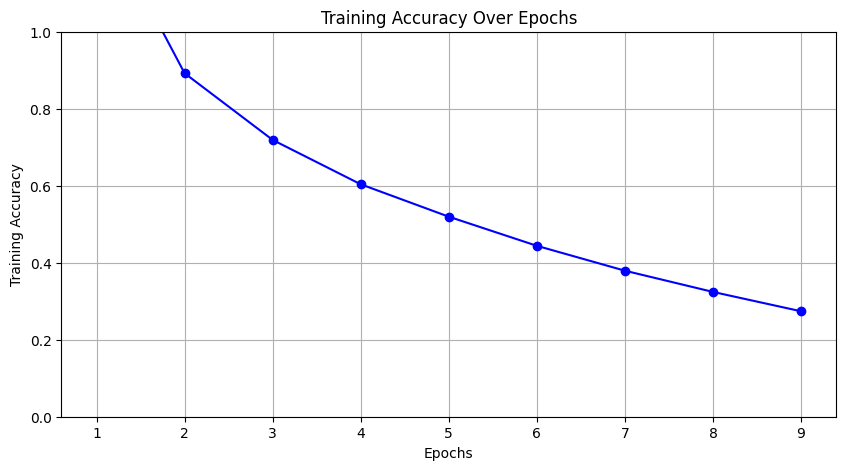

In [ ]:
epochs = list(range(1, len(train_losses) + 1))

plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, marker='o', linestyle='-', color='b')
plt.title('Training Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training Accuracy')
plt.xticks(epochs)
plt.grid()
plt.ylim(0, 1)
plt.show()

## Model 2
for the below model, the input channels are 4 RBG and the number of output channels are increase as the network goes deeper.

From, 32 -> 64 -> 128 -> 256.

After each convolutional layer, batch
normalisation is applied, to normalise the output of the previous layer The activation used us Leaky ReLU after each convolutional layer and fully connected layer.

Max Pooling layer is used to downsample the feature maps, reducing dimensions.

Dropout is included after the 2nd convolutional layer with 0.3 value and after first fully connected layer.

After all the layers we are going to flatten the output to a fully connected layer converting 3D tensors to 1D tensor.

At the end of the layers we are using nn.Linear to prevent overfitting the model. Since we have 10 classes we are using 10 output united at the end.


**Optimizer**: Stochastic Gradient Descent (optim.SGD) is used with a learning rate of 0.001.
**Loss Fn**: CrossEntropyloss is used for multi class classification

In [ ]:
class ModifiedNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),  # 5 by 5
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),  # activation to LeakyReLU

            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),
            nn.Dropout(0.3),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # kernel size to 3x3
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Flatten(),
            nn.Linear(256 * 8 * 8, 2048),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)


model2 = ModifiedNet()
model2.to(device)

optimizer = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 12

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

predictions = []
true_labels = []

for epoch in range(num_epochs):
    model2.train()
    total_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for batch_images, batch_labels in train_loader:
        batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)

        outputs = model2(batch_images)
        loss = criterion(outputs, batch_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        _, predicted_labels = torch.max(outputs.data, 1)
        correct_predictions += (predicted_labels == batch_labels).sum().item()
        total_samples += batch_labels.size(0)

    model2.eval()
    total_val_loss = 0.0
    correct_val_predictions = 0
    val_total_samples = 0

    with torch.no_grad():
        for batch_images, batch_labels in val_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            true_labels.append(batch_labels)

            outputs = model2(batch_images)
            loss = criterion(outputs, batch_labels)
            total_val_loss += loss.item()

            _, predicted_labels = torch.max(outputs.data, 1)
            predictions.append(predicted_labels)
            val_total_samples += batch_labels.size(0)
            correct_val_predictions += (predicted_labels == batch_labels).sum().item()

    average_train_loss = total_loss / len(train_loader)
    training_accuracy = (correct_predictions / total_samples) * 100

    train_losses.append(average_train_loss)
    train_accuracies.append(training_accuracy)

    average_val_loss = total_val_loss / len(test_loader)
    val_losses.append(average_val_loss)
    validation_accuracy = (correct_val_predictions / val_total_samples) * 100

    print(f"Epoch={epoch + 1}, Training [Loss, accuracy]: [{average_train_loss:.4f}, {training_accuracy:.2f}%], \
    Validation [Loss,accuracy]: [{average_val_loss:.4f}, {validation_accuracy:.2f}%]")


Epoch=1, Training [Loss, accuracy]: [1.5815, 42.52%],     Validation [Loss,accuracy]: [0.6410, 53.44%]
Epoch=2, Training [Loss, accuracy]: [1.0853, 61.10%],     Validation [Loss,accuracy]: [0.5325, 61.86%]
Epoch=3, Training [Loss, accuracy]: [0.9122, 67.57%],     Validation [Loss,accuracy]: [0.4950, 64.38%]
Epoch=4, Training [Loss, accuracy]: [0.8005, 71.61%],     Validation [Loss,accuracy]: [0.4806, 66.82%]
Epoch=5, Training [Loss, accuracy]: [0.7225, 74.50%],     Validation [Loss,accuracy]: [0.3822, 73.24%]
Epoch=6, Training [Loss, accuracy]: [0.6570, 76.87%],     Validation [Loss,accuracy]: [0.3871, 73.62%]
Epoch=7, Training [Loss, accuracy]: [0.6009, 78.58%],     Validation [Loss,accuracy]: [0.3295, 77.74%]
Epoch=8, Training [Loss, accuracy]: [0.5487, 80.53%],     Validation [Loss,accuracy]: [0.3276, 77.12%]
Epoch=9, Training [Loss, accuracy]: [0.5016, 82.24%],     Validation [Loss,accuracy]: [0.3643, 75.52%]
Epoch=10, Training [Loss, accuracy]: [0.4566, 83.99%],     Validation [Lo

In [ ]:
def predict_test(model):
    model.eval()
    test_loss = 0.0
    correct_test_predictions = 0
    test_total_samples = 0

    test_predictions = []
    test_true_labels = []

    with torch.no_grad():
        for batch_images, batch_labels in test_loader:
            batch_images, batch_labels = batch_images.to(device), batch_labels.to(device)
            test_true_labels.append(batch_labels)

            outputs = model(batch_images)
            loss = criterion(outputs, batch_labels)
            test_loss += loss.item()

            _, predicted_labels = torch.max(outputs.data, 1)
            test_predictions.append(predicted_labels)

            test_total_samples += batch_labels.size(0)
            correct_test_predictions += (predicted_labels == batch_labels).sum().item()
    print("Test Loss:", test_loss / len(test_loader))
    print("Test Accuracy:", (correct_test_predictions / test_total_samples) * 100)
    return test_predictions, test_true_labels
test_predictions1, test_true_labels1 = predict_test(model)
test_predictions2, test_true_labels2 = predict_test(model2)

Test Loss: 0.5224467100093539
Test Accuracy: 83.28999999999999
Test Loss: 0.6570166557932052
Test Accuracy: 78.86


## Result
The model 1 demonstrates better performance with a lower test loss of 0.5224 and a higher test accuracy of 83.29%. This indicates that the model effectively learned to classify the data during training and generalizes well to the test set.

The model 2, while still performing reasonably well, has a higher test loss of 0.6570 and a lower test accuracy of 78.86%. This suggests that it struggles more than the first model in accurately predicting the test set classes. the possible reason can be that the model 2 has less layers than the model 1, despite the Leaky ReLU and dropouts.

In [ ]:
def eval(true_labels, predicted_labels):
    true_labels = torch.cat(true_labels).cpu().numpy()
    predicted_labels = torch.cat(predicted_labels).cpu().numpy()

    accuracy = accuracy_score(true_labels, predicted_labels)

    precision = precision_score(true_labels, predicted_labels, average=None)
    recall = recall_score(true_labels, predicted_labels, average=None)
    f1 = f1_score(true_labels, predicted_labels, average=None)

    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    print("Accuracy:", accuracy)
    print("Precision per class:", precision)
    print("Recall per class:", recall)
    print("F1 Score per class:", f1)
    print("Confusion Matrix:\n", conf_matrix)

    macro_precision = precision_score(true_labels, predicted_labels, average='macro')
    macro_recall = recall_score(true_labels, predicted_labels, average='macro')
    macro_f1 = f1_score(true_labels, predicted_labels, average='macro')

    micro_precision = precision_score(true_labels, predicted_labels, average='micro')
    micro_recall = recall_score(true_labels, predicted_labels, average='micro')
    micro_f1 = f1_score(true_labels, predicted_labels, average='micro')

    print("Macro Precision:", macro_precision)
    print("Macro Recall:", macro_recall)
    print("Macro F1 Score:", macro_f1)

    print("Micro Precision:", micro_precision)
    print("Micro Recall:", micro_recall)
    print("Micro F1 Score:", micro_f1)


eval(test_true_labels1, test_predictions1)
eval(test_true_labels2, test_predictions2)

Accuracy: 0.8329
Precision per class: [0.75203252 0.83797909 0.8265896  0.71515152 0.82617188 0.76367188
 0.86315789 0.90697674 0.92842105 0.95980512]
Recall per class: [0.925 0.962 0.715 0.708 0.846 0.782 0.902 0.819 0.882 0.788]
F1 Score per class: [0.82959641 0.89571695 0.76675603 0.71155779 0.83596838 0.77272727
 0.88215159 0.86074619 0.90461538 0.86545854]
Confusion Matrix:
 [[925  15  14   6   3   2   0   3  26   6]
 [ 10 962   2   3   2   1   2   0   6  12]
 [ 84   2 715  45  49  48  41  12   4   0]
 [ 33   6  35 708  35 112  40  17  10   4]
 [ 30   1  32  31 846  10  29  18   3   0]
 [ 18   4  21 113  30 782  13  19   0   0]
 [ 14   2  23  35  11   7 902   4   2   0]
 [ 26   3  15  23  47  59   3 819   3   2]
 [ 56  26   5  10   0   2   7   3 882   9]
 [ 34 127   3  16   1   1   8   8  14 788]]
Macro Precision: 0.8379957282196109
Macro Recall: 0.8329000000000001
Macro F1 Score: 0.8325294535190085
Micro Precision: 0.8329
Micro Recall: 0.8329
Micro F1 Score: 0.8329
Accuracy: 0.78

In [ ]:
torch.save(model2.state_dict(), 'cifar10_model2.pth')

In [ ]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
def predict_image(img, model):
    img = img.unsqueeze(0).to(device)
    outputs = model(img)
    _, predicted_labels = torch.max(outputs.data, 1)
    return classes[predicted_labels]

Label: airplane , Predicted: airplane


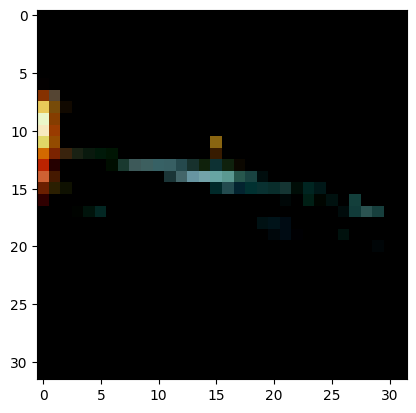

In [ ]:
img, label = testset[1001]
plt.imshow(img.permute(1, 2, 0))
print('Label:', classes[label], ', Predicted:', predict_image(img, model))